# Loading and Accessing SnowModel Output

Snow cover data for the Sunlight Under Sea Ice project are generated by SnowModel-LG [(Liston et al)]().  This model output includes snow depth and density, which can be downloaded from [Here](ftp://ftp.cira.colostate.edu/ftp/Liston/SnowModel_LG_1980-2018/Data/).  Fields are in the NSIDC North Polar Stereographic projection on the X grid.

Output from SnowModel-LG are stored in [GrADS](http://cola.gmu.edu/grads/grads.php) format.  GrADS is a complete analysis system.  All we want here is to read the files, and then perform analysis using the GeoScientific Python ecosystem. So I have written a simple GrADS reader that loads data into an `xarray.DataArray`.

GrADS data requires two files: a flat binary file (often with a `.gdat` extension) and a control file (`.ctl`).  The control file contains information about the dimensions and coordinates of the `.gdat` file, as well as information about the variables contained within that file.  `read_grads` expects `.ctl` and `.gdat` files to have the same basename and be in the same directory.  If they do not, the `.ctl` needs to be passed to `read_grads` as a keyword argument.

As a first step, we import python modules.

In [1]:
import os
import sys

sys.path.append("../sunderseaice")  # Add `sunlight` to $PYTHONPATH

import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import xarray as xr

from readers.snowmodel import read as read_snowmodel

Set the path to the data.  As an example, I'm reading the snow depth fields.

In [2]:
DATAPATH = os.path.join(os.path.sep, "home", "apbarret", "Data", "Snow_on_seaice", "SnowModelOutput")
datafile = os.path.join(DATAPATH, "MERRA2", "snod.gdat")
ctlfile = os.path.join(DATAPATH, "MERRA2", "SM_snod_merra2_01Aug1980-31Jul2018.ctl")
#datafile = os.path.join(DATAPATH, "ERA5", snod.gdat")
#ctlfile = os.path.join(DATAPATH, "ERA5", SM_snod_era5_01Aug1980-31Jul2018.ctl")

Load data into an xarray object.  These are large files, so you may run into some memory issues.  `read_snowmodel` returns a dask DataArray but I need to improve this to help with these out-of-memory conditions.

In [3]:
snowDepth = read_snowmodel(datafile, ctlfile)
snowDepth

,Array,Chunk
Bytes,7.23 GB,52.13 MB
Shape,"(13879, 361, 361)","(100, 361, 361)"
Count,279 Tasks,139 Chunks
Type,float32,numpy.ndarray


`snowDepth` is an `xarray.DataArray` object.  Variables and coordinates do not have attributes.  Adding attributes is on the TBD list.  The x and y coordinates are projected coordinates of the NSIDC EASE 25km North Grid.

Fields can be plotted using the `xarray.DataArray.plot()` method.  A single timestep needs to be selected to plot an image.  If all timesteps are selected, the call to plot will produce a histogram.

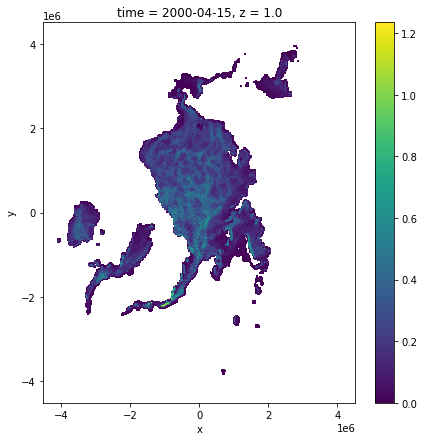

In [4]:
fig, ax = plt.subplots(figsize=(7,7))
snowDepth.sel(time='2000-04-15').plot(ax=ax)

In [5]:
SphericalEarth = ccrs.Globe(semimajor_axis=6371228., semiminor_axis=6371228.)
NSIDC_EASE = ccrs.LambertAzimuthalEqualArea(central_latitude=90., central_longitude=0., globe=SphericalEarth)

extent = [-4524683.8, 4524683.8, -4524683.8, 4524683.8]

Need to figure out geotransform and how xarray indexes arrays

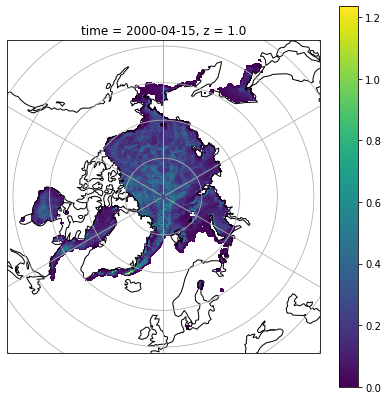

In [6]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection=NSIDC_EASE)
ax.set_extent(extent, NSIDC_EASE)
ax.coastlines()
ax.gridlines()
snowDepth.sel(time='2000-04-15').plot(ax=ax)

In [7]:
ds = snowDepth.to_dataset(name='snow_depth')
ds = ds.drop('z')
ds

,Array,Chunk
Bytes,7.23 GB,52.13 MB
Shape,"(13879, 361, 361)","(100, 361, 361)"
Count,279 Tasks,139 Chunks
Type,float32,numpy.ndarray


## Generate 2-dimensional latitude and longitude grids

In [ ]:
x2d, y2d = np.meshgrid(ds.x, ds.y)
geo_proj = ccrs.PlateCarree(globe=NSIDC_EASE.globe)
geo_coords = geo_proj.transform_points(NSIDC_EASE, x2d, y2d)
lon = geo_coords[:, :, 0]
lat = geo_coords[:, :, 1]

ds['lon'] = xr.DataArray(lon, coords=[ds.x, ds.y], dims=['x', 'y'])
ds['lat'] = xr.DataArray(lat, coords=[ds.x, ds.y], dims=['x', 'y'])

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection=NSIDC_EASE)
ax.set_extent(extent, NSIDC_EASE)
ax.coastlines()
ax.gridlines()
ax.pcolormesh(lon, lat, ds.snow_depth.sel(time='2000-04-15'), transform=geo_proj)

## Create global and varable attributes

In [ ]:
ds.attrs = {
    'title': 'snow depth on sea ice',
    'institution': 'CIRA, Colorado State University',
    'creator': 'Glen.Liston@colostate.edu',
    'source': 'SnowModel-LG',
    'projection': 'NSIDC EASE',
    'proj4_string': NSIDC_EASE.proj4_init,
    'crs': 'EPSG:3408',
    'reference': ('Liston, G. E., Itkin, P., Stroeve, J., Tschudi, M., Stewart, J. S., & Pedersen, S. H., et al. (2020). '
                  'A Lagrangian snow‐evolution system for sea‐ice applications (SnowModel‐LG): Part I—Model description. '
                  'Journal of Geophysical Research: Oceans, 125, e2019JC015913. https://doi.org/10.1029/2019JC015913')
}

ds.snow_depth.attrs = {
    'long_name': 'snow depth',
    'standard_name': 'surface_snow_thickness_where_sea_ice',
    'units': 'm'
}

ds.lon.attrs = {
    'long_name': 'longitude',
    'units': 'degrees_east'
}

ds.lat.attrs = {
    'long_name': 'latitude',
    'units': 'degrees_north'
}

ds.time.attrs = {
    'long_name': 'time',
}

ds.x.attrs = {
    'long_name': 'x-coordinate of projection',
    'standard_name': 'projection_x_coordinate',
    'units': 'm',    
}

ds.y.attrs = {
    'long_name': 'y-coordinate of projection',
    'standard_name': 'projection_y_coordinate',
    'units': 'm',    
}



In [ ]:
ds

In [ ]:
ds.transpose("time", "x", "y")

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection=NSIDC_EASE)
ax.set_extent(extent, NSIDC_EASE)
ax.coastlines()
ax.gridlines()
ds.snow_depth.sel(time='2000-04-15').plot(ax=ax)

In [ ]:
encoding = {
    'snow_depth': {
        'zlib': True,
        'complevel': 9,
        '_FillValue': -9999.99
    },
}
ds.load()

In [ ]:
ds.to_netcdf('snow_depth_test.nc', encoding=encoding)